# Double 7

This is an example of an automated trading strategy, how to trade on a single trading pair using daily closes and moving averages.

* You can read more about the strategy on the [The Chartist explanation page](https://www.thechartist.com.au/double-7-s-strategy/)

* The strategy trades a single chosen token pair, in our case ETH-USD (using USDC stablecoin)

* The strategy trades on Sushiswap and on Ethereum mainnet

* The backtesting is done using [Backtrader backtesting framework](https://tradingstrategy.ai/docs/glossary.html#term-Backtrader)

* The strategy is converted to Backtrader from its original [Pine Script](https://tradingstrategy.ai/docs/glossary.html#term-Pine-Script) implementation

* Based on the backtesting, the strategy is real-life profitable

* The chosen parameters (50 days moving average, 7 days high, 7 days close, daily candles) were arbitrarily chosen and might be unfit for the crypto markets directly as such. It is necessary to modify and test a suitable timeframe and MA configuration for your chosen trading pair.

* Please notice, the backtesting does not account for transaction fees, trading fees, or slippage.

## The original Double 7 Pine Script implementation

Below is the Double 7 Pine Script implementation that this strategy is based on.

```
//@version=4
strategy("Double 7's Strat.v1", overlay=true, default_qty_type = strategy.percent_of_equity, default_qty_value = 100)

value1=input(7, title="Quantity of day low")
value2=input(7, title="Quantity of day high")
entry=lowest(close[1],value1)
exit=highest(close[1],value2)

mma100=sma(close,100)

plot(entry, title = '7 day low', color = color.blue,   linewidth = 1, style = plot.style_linebr)  // plot 7 day low
plot(exit, title = '7 day high', color = color.purple,   linewidth = 1, style = plot.style_linebr)  // plot 7 day high
plot(mma100, title = 'MMA100', color = color.orange,   linewidth = 2, style = plot.style_line)  // plot MMA100

//Stop Loss input setting
longLossPerc = input(title="Long Stop Loss (%)", type=input.float, minval=0.0, step=0.1, defval=1) * 0.01

// Determine stop loss price
longStopPrice  = strategy.position_avg_price * (1 - longLossPerc)

// Plot stop loss values for confirmation
plot(series=(strategy.position_size > 0) ? longStopPrice : na, color=color.red, style=plot.style_linebr, linewidth=2, title="Long Stop Loss")

// Test Period
testStartYear = input(2021, "Backtest Start Year")
testStartMonth = input(5, "Backtest Start Month")
testStartDay = input(17, "Backtest Start Day")
testPeriodStart = timestamp(testStartYear,testStartMonth,testStartDay,0,0)

testStopYear = input(2022, "Backtest Stop Year")
testStopMonth = input(12, "Backtest Stop Month")
testStopDay = input(30, "Backtest Stop Day")
testPeriodStop = timestamp(testStopYear,testStopMonth,testStopDay,0,0)

testPeriod() =>
    time >= testPeriodStart and time <= testPeriodStop ? true : false

if testPeriod()
    if (close>mma100) and (close<entry)
        strategy.entry("RsiLE", strategy.long , comment="Open")

    if (close>exit)
        strategy.close_all()

// Submit exit orders based on calculated stop loss price
if (strategy.position_size > 0)
    strategy.exit(id="XL STOP", stop=longStopPrice)
```

## Strategy and backtesting parameters

Here we define all parameters that affect the backtesting outcome.

In [1]:
import pandas as pd
from tradingstrategy.timebucket import TimeBucket
from tradingstrategy.chain import ChainId

# Which pair we analyse
# https://analytics.sushi.com/pairs/0x06da0fd433c1a5d7a4faa01111c044910a184553
TARGET_PAIR = ("WETH", "USDC")

# The backtest only consider Ethereum mainnet
BLOCKCHAIN = ChainId.ethereum

# The backtest only considers Sushiswap v2 exchange
EXCHANGE = "sushiswap"

# Use daily candles for backtesting
CANDLE_KIND = TimeBucket.d1

# The moving average must be above of this number for us to buy
MOVING_AVERAGE_CANDLES = 50

# How many previous candles we sample for the low close value
LOW_CANDLES = 7

# How many previous candles we sample for the high close value
HIGH_CANDLES = 7

# When do we start the backtesting - limit the candle set from the data dump from the server
BACKTESTING_BEGINS = pd.Timestamp("2020-10-1")

# When do we end backtesting
BACKTESTING_ENDS = pd.Timestamp("2021-09-1")

## Initialising the Trading Strategy client

This step will install necessary Python packages and the needed API keys.

Note that Google Colab may need you to restart the notebook after the package installation is complete.

In [2]:
try:
    import tradingstrategy
except ImportError:
    !pip install tradingstrategy
    import site
    site.main()

from tradingstrategy.client import Client

client = Client.create_jupyter_client()

Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy


## Creating the strategy

Here is the strategy defined for Backtrader.

In [3]:
import backtrader as bt
from backtrader import indicators


class Double7(bt.Strategy):
    """An example of double-77 strategy for DEX spot trading.

    The original description: https://www.thechartist.com.au/double-7-s-strategy/
    """

    def start(self):
        # Set up indicators used in this strategy

        # Moving average that tells us when we are in the bull market
        self.moving_average = indicators.SMA(period=MOVING_AVERAGE_CANDLES)

        # The highest close price for the N candles
        # "exit" in pine script
        self.highest = indicators.Highest(self.data.close, period=HIGH_CANDLES)

        # The lowest close price for the N candles
        # "entry" in pine script
        self.lowest = indicators.Lowest(self.data.close, period=LOW_CANDLES)

        # Count ticks and some basic testing metrics
        self.ticks = self.enters = self.exits = 0

    def next(self):
        """Execute a decision making tick for each candle."""

        self.ticks += 1

        # Get the last value of the current candle close and indicators
        # More about self.data and self.lines of Backtrader
        # https://github.com/backtrader/backtrader-docs/blob/master/docs/concepts.rst#indexing-0-and--1
        # https://www.fatalerrors.org/a/backtrader-3-core-concept-lines.html.
        # Note that the value can be "nan" if we have not ticked enough days and
        # e.g. the moving average cannot be calculated.
        # Zero means "today" or the indicator value at the current candle.
        # Minus one means "yesterday" or the indicator value at the previous candle.
        # (Indexing might be different from the pine script)
        close = self.data.close[0]
        low = self.lowest[-1]
        high = self.highest[-1]
        avg = self.moving_average[0]

        # Print debug logs so that analysing the strategy internal thinking is easier
        print(f"Tick: {self.ticks}, close: {close}, avg: {avg}, low: {low}, high: {high}")

        if not all([close, low, high, avg]):
            # Do not try to make any decision if we have nan or zero data
            return

        # Enter when we are above moving average and the daily close was
        if close >= avg and close <= low and not self.position:
            print("Entered to a position")
            self.buy()

        # If the price closes above its 7 day high, exit from the markets
        if close >= high and self.position:
            print("Exited the position")
            self.close()

## Setting up the strategy backtest

This set ups the data sources and plumping for running the backtest ("boilerplate" in software development terms).

In [4]:
from backtrader import analyzers

from tradingstrategy.chain import ChainId
from tradingstrategy.frameworks.backtrader import prepare_candles_for_backtrader, add_dataframes_as_feeds
from tradingstrategy.pair import PandasPairUniverse


# Operate on daily candles
strategy_time_bucket = CANDLE_KIND

exchange_universe = client.fetch_exchange_universe()
columnar_pair_table = client.fetch_pair_universe()
all_pairs_dataframe = columnar_pair_table.to_pandas()
pair_universe = PandasPairUniverse(all_pairs_dataframe)

# Filter down to pairs that only trade on Sushiswap
sushi_swap = exchange_universe.get_by_name_and_chain(ChainId.ethereum, EXCHANGE)
pair = pair_universe.get_one_pair_from_pandas_universe(
    sushi_swap.exchange_id,
    TARGET_PAIR[0],
    TARGET_PAIR[1])

all_candles = client.fetch_all_candles(strategy_time_bucket).to_pandas()
pair_candles: pd.DataFrame = all_candles.loc[all_candles["pair_id"] == pair.pair_id]
pair_candles = prepare_candles_for_backtrader(pair_candles)

# We limit candles to a specific date range to make this notebook deterministic
pair_candles = pair_candles[(pair_candles.index >= BACKTESTING_BEGINS) & (pair_candles.index <= BACKTESTING_ENDS)]

print(f"Out candle universe size is {len(pair_candles)}")

# This strategy requires data for 100 days. Because we are operating on new exchanges,
# there simply might not be enough data there
assert len(pair_candles) > MOVING_AVERAGE_CANDLES, "We do not have enough data to execute the strategy"

# Create the Backtrader back testing engine "Cebebro"
cerebro = bt.Cerebro(stdstats=True)

# Add out strategy
cerebro.addstrategy(Double7)

# Add two analyzers for the strategy performance
cerebro.addobserver(bt.observers.Value)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)
cerebro.addanalyzer(bt.analyzers.Returns)
cerebro.addanalyzer(bt.analyzers.DrawDown)


# Add our SUSHI-ETH price feed
add_dataframes_as_feeds(
    cerebro,
    pair_universe,
    [pair_candles],
    BACKTESTING_BEGINS,
    BACKTESTING_ENDS,
    strategy_time_bucket)


Out candle universe size is 336


## Running the backtest

Now when everything has been set up we execute the backtest. Because the dataset is small (~300 candles) this takes a fraction of a second.

In [5]:
results = cerebro.run()

Tick: 1, close: 352.85247802734375, avg: nan, low: 3093.651123046875, high: 3815.57666015625
Tick: 2, close: 346.1255187988281, avg: nan, low: nan, high: nan
Tick: 3, close: 348.4530334472656, avg: nan, low: nan, high: nan
Tick: 4, close: 350.6174011230469, avg: nan, low: nan, high: nan
Tick: 5, close: 351.46832275390625, avg: nan, low: nan, high: nan
Tick: 6, close: 338.0306396484375, avg: nan, low: nan, high: nan
Tick: 7, close: 339.6888427734375, avg: nan, low: nan, high: nan
Tick: 8, close: 351.3641357421875, avg: nan, low: 338.0306396484375, high: 352.85247802734375
Tick: 9, close: 365.0035705566406, avg: nan, low: 338.0306396484375, high: 351.46832275390625
Tick: 10, close: 370.5841979980469, avg: nan, low: 338.0306396484375, high: 365.0035705566406
Tick: 11, close: 372.5084533691406, avg: nan, low: 338.0306396484375, high: 370.5841979980469
Tick: 12, close: 389.1968994140625, avg: nan, low: 338.0306396484375, high: 372.5084533691406
Tick: 13, close: 380.4424133300781, avg: nan, 

## Analyzing the strategy results

After the strategy is run, we will display charts and statistics on its performance.
We use Backtrader internal analysis tools for this.

In [6]:
strategy: Double7 = results[0]

### Key figures

Some standard performance figures for quantative finance.

In [7]:
print(f"Backtest range {BACKTESTING_BEGINS.date()} - {BACKTESTING_ENDS.date()}")
print(f"Sharpe: {strategy.analyzers.sharperatio.get_analysis()['sharperatio']:.3f}")
print(f"Norm. annual return: {strategy.analyzers.returns.get_analysis()['rnorm100']:.2f}%")
print(f"Max drawdown: {strategy.analyzers.drawdown.get_analysis()['max']['drawdown']:.2f}%")

Backtest range 2020-10-01 - 2021-09-01
Sharpe: 1.793
Norm. annual return: 4.69%
Max drawdown: 14.28%


### Portfolio development and trades made

This Backtrader default chart will display the portfolio value
develoment and when the individual trades were made.

<IPython.core.display.Javascript object>

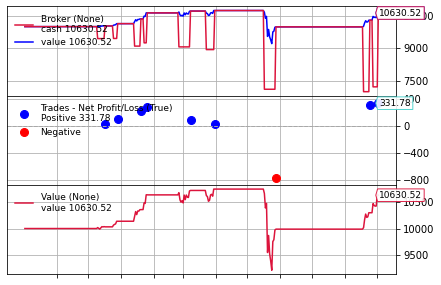

In [8]:
from matplotlib.figure import Figure

figs = cerebro.plot(iplot=True)

# The breakdown for the first strategy
figs[0][0]
#figs